In [18]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from matplotlib import pyplot
import matplotlib.pyplot as plt
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.utils import to_categorical


In [7]:

def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded
 
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'HAR/')
    testX, testy = load_dataset_group('test', prefix + 'HAR/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [10]:
trainX, trainy, testX, testy = load_dataset('data/')

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [11]:
def plot_distributions(trainX):

    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]

    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    pyplot.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        pyplot.hist(longX[:, i], bins=100)
    pyplot.show()

(470528, 9)


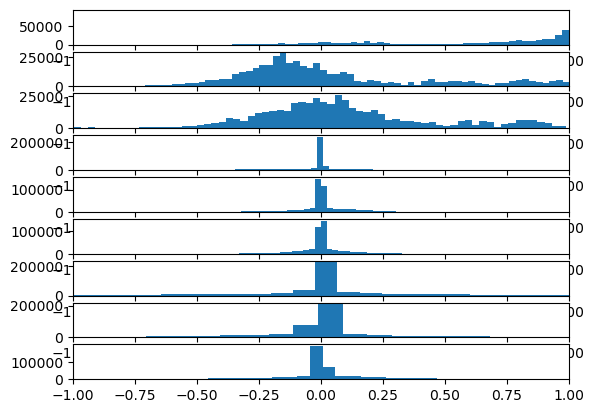

In [12]:
plot_distributions(trainX)

In [13]:
batch_size = 64
validation_split = 0.2

In [20]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)
     

Epoch 1/10
92/92 [==============================] - 20s 175ms/step - loss: 1.3561 - accuracy: 0.4132 - val_loss: 1.2659 - val_accuracy: 0.3984
Epoch 2/10
92/92 [==============================] - 14s 153ms/step - loss: 0.9270 - accuracy: 0.5919 - val_loss: 0.8690 - val_accuracy: 0.6778
Epoch 3/10
92/92 [==============================] - 14s 153ms/step - loss: 0.6819 - accuracy: 0.6815 - val_loss: 0.8310 - val_accuracy: 0.7424
Epoch 4/10
92/92 [==============================] - 14s 155ms/step - loss: 0.6219 - accuracy: 0.7381 - val_loss: 0.9112 - val_accuracy: 0.7492
Epoch 5/10
92/92 [==============================] - 14s 152ms/step - loss: 0.4514 - accuracy: 0.8344 - val_loss: 0.6732 - val_accuracy: 0.8083
Epoch 6/10
92/92 [==============================] - 14s 149ms/step - loss: 0.3101 - accuracy: 0.8981 - val_loss: 0.5115 - val_accuracy: 0.8885
Epoch 7/10
92/92 [==============================] - 14s 151ms/step - loss: 0.2317 - accuracy: 0.9240 - val_loss: 0.4702 - val_accuracy: 0.8804

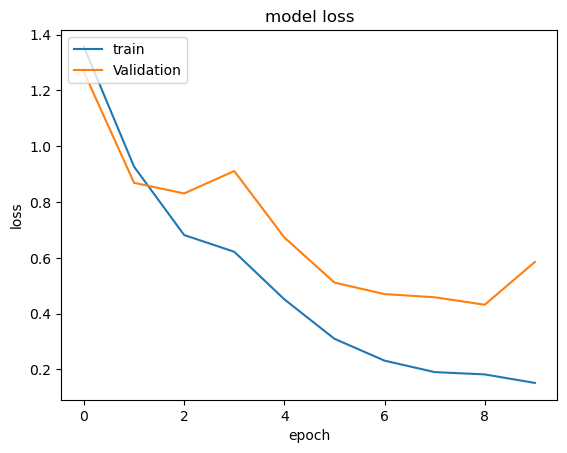

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
     

In [24]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8744485974311829
93/93 [==============================] - 4s 34ms/step


In [25]:
predictions

array([[8.2922442e-04, 3.3138764e-05, 3.9502775e-06, 1.4943537e-02,
        9.8417920e-01, 1.0867155e-05],
       [9.0637803e-04, 3.3380835e-05, 3.4380580e-06, 1.2270471e-02,
        9.8677760e-01, 8.6739537e-06],
       [8.8412146e-04, 3.2697586e-05, 3.1736515e-06, 1.1043249e-02,
        9.8802882e-01, 7.8383928e-06],
       ...,
       [1.1963644e-03, 9.9516040e-01, 3.6188182e-03, 7.4624209e-06,
        3.4031018e-06, 1.3522470e-05],
       [1.3839728e-03, 9.9770039e-01, 8.8299892e-04, 9.2133478e-06,
        5.8093783e-06, 1.7679398e-05],
       [4.2334042e-04, 9.9916112e-01, 4.0871729e-04, 1.8355627e-06,
        1.9125498e-06, 3.1318004e-06]], dtype=float32)

In [26]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[462   7  27   0   0   0]
 [  5 441  25   0   0   0]
 [  2   3 415   0   0   0]
 [  1  19   0 412  54   5]
 [  0   2   0  86 444   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

     Walking       0.98      0.93      0.96       496
      Walkup       0.86      0.94      0.89       471
    Walkdown       0.89      0.99      0.94       420
     Sitting       0.83      0.84      0.83       491
    Standing       0.89      0.83      0.86       532
      Laying       0.99      0.92      0.95       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



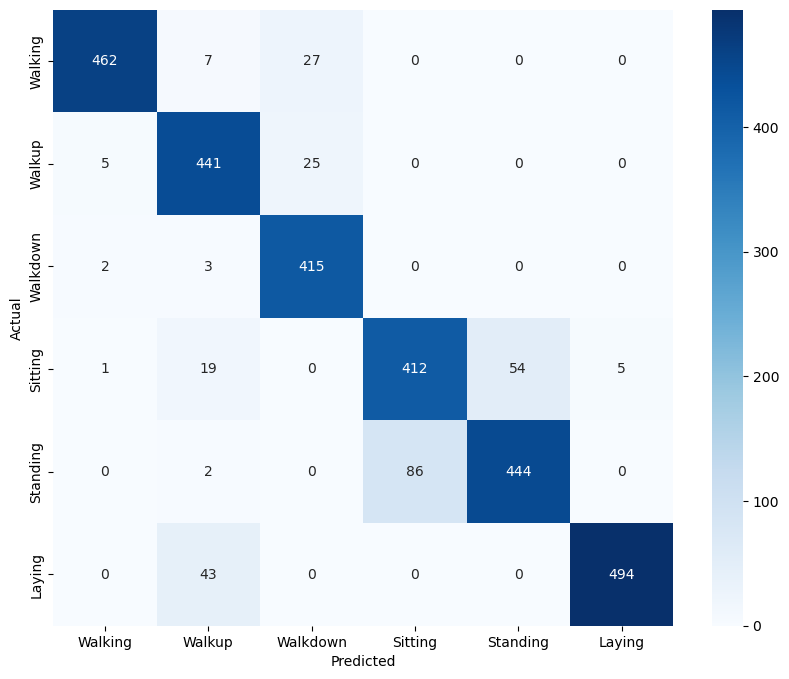

In [41]:
classNames=["Walking","Walkup","Walkdown","Sitting","Standing","Laying"]
display_results(testy,predictions,classNames)

In [35]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)
   

Epoch 1/20
92/92 [==============================] - 6s 52ms/step - loss: 0.4592 - accuracy: 0.8179 - val_loss: 0.3719 - val_accuracy: 0.8912
Epoch 2/20
92/92 [==============================] - 5s 50ms/step - loss: 0.1589 - accuracy: 0.9403 - val_loss: 0.3276 - val_accuracy: 0.9082
Epoch 3/20
92/92 [==============================] - 5s 50ms/step - loss: 0.1062 - accuracy: 0.9561 - val_loss: 0.3874 - val_accuracy: 0.9089
Epoch 4/20
92/92 [==============================] - 5s 49ms/step - loss: 0.1081 - accuracy: 0.9531 - val_loss: 0.4095 - val_accuracy: 0.9137
Epoch 5/20
92/92 [==============================] - 5s 51ms/step - loss: 0.0959 - accuracy: 0.9599 - val_loss: 0.4696 - val_accuracy: 0.9055
Epoch 6/20
92/92 [==============================] - 4s 47ms/step - loss: 0.0889 - accuracy: 0.9597 - val_loss: 0.5140 - val_accuracy: 0.9109
Epoch 7/20
92/92 [==============================] - 4s 47ms/step - loss: 0.0838 - accuracy: 0.9628 - val_loss: 0.4857 - val_accuracy: 0.9041
Epoch 8/20
92

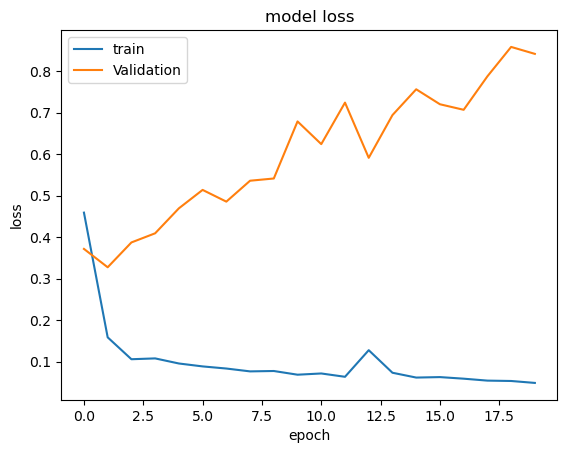

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [39]:
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.9053274393081665
93/93 [==============================] - 1s 6ms/step


**** Confusion Matrix ****
[[462   7  27   0   0   0]
 [  5 441  25   0   0   0]
 [  2   3 415   0   0   0]
 [  1  19   0 412  54   5]
 [  0   2   0  86 444   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.98      0.93      0.96       496
           2       0.86      0.94      0.89       471
           3       0.89      0.99      0.94       420
           4       0.83      0.84      0.83       491
           5       0.89      0.83      0.86       532
           6       0.99      0.92      0.95       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



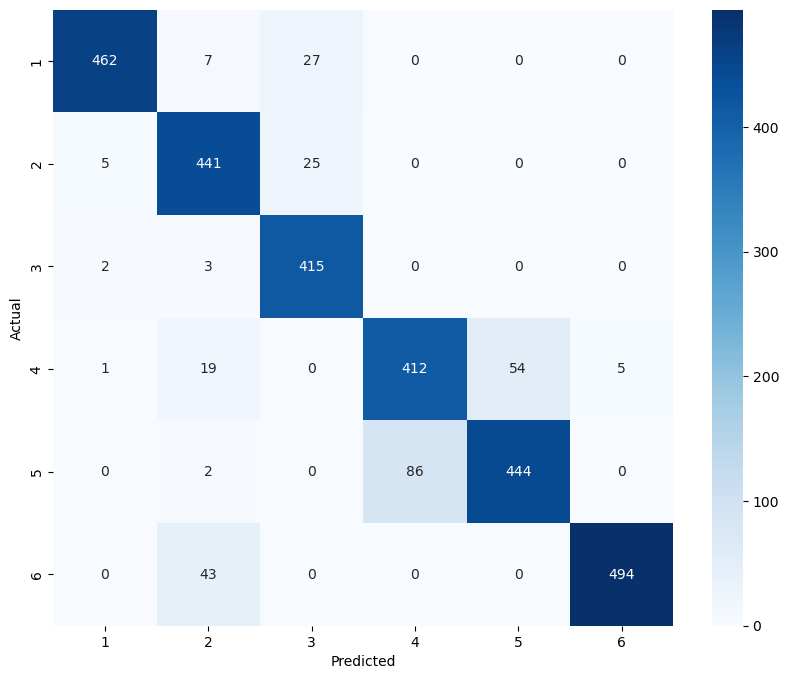

In [40]:
display_results(testy,predictions,classNames)